In [2]:
# Imports (if running in JupyterLite this might take a while)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
print("Enter ideas. You can enter them one-by-one, or enter them all at once, separated with a newline.")
ideas = []
answer = ""
while answer != "exit":
    answer = input()
    ideas.extend([idea for idea in answer.split('\n') if idea.strip() and idea != "exit"])

print(ideas)

In [6]:
ideas = [
    "Ask why clients who had a paid 1000minds license chose to stop using it.",
    "Being acknowledged by the MCDA and CA academic worlds as a bona fide (superior) method to be taken seriously.",
    "Build brand recognition and reputation – 1000minds as a mark or certification of a decision or prioritization well made.",
    "Converting more leads to paying clients.",
    "Dedicated sales team.",
    "Despite our best efforts, sales process is a bit too casual and ad hoc (albeit we are gradually improving it).",
    "Developing a social media strategy and posting useful content more frequently can make more people aware of our brand.",
    "Drop the price of 1000minds licenses to a flat $1000 per user.",
    "Get our product under the nose of decision-makers everywhere – somehow :)",
    "Improve product/flow for group decision-making.",
    "Keep building cool new features and usable / attractive designs that will attract/keep customers over competing products.",
    "Keep innovating to stay ahead of the competition and satisfy changing customer needs (e.g., creating new features, enhancing the current product, or introducing completely new solutions)",
    "Lack of standardized sales process I suppose. Like with phases, scripts, etc. Something that could be refined over time same way we refine our app.",
    "More high quality leads (well-funded company with clear need for decision-making tools).",
    "More projects with the consultants who already know and like us (currently there are many consultants on our sales board who are “waiting for the right project”).",
    "Not enough reach for general public. It’s hard to communicate the value over intuitive decision-making. A kick-start of this could be something that solves more trivial decision problems? So we can apply 1000minds not only for ‘important’ decisions, but for ‘trivial’ too? Like a 3-clicks plugin for Slack that helps group to decide which of 4 images that are being considered is the best to use for a given application?",
    "Not having fully figured out how to make the most of AI in 1000minds, e.g. interface, chat, integration at various touchpoints in 1000minds.",
    "Often do a simple version first and say we will do the “extras” later, but sometimes the extras are what might make the difference to get people to convert.",
    "Our product could be used by most businesses, which could open up our market immensely but they need education on why they need a decision-making software and why they should invest in it. There is a cost involved in doing this type of demand generation marketing, and uncertainty in results compared to focusing on industries that we think are most likely to already understand the product somewhat.",
    "Partner with an existing sales team/company.",
    "Partner with an investor who has exceptional sales/marketing experience.",
    "Support the Analytic Hierarchy Process (AHP) method (100 times more potential customers)",
    "The product is in a good place (design/dev) but we need more customers who pay us well, and continue to pay. Hopefully, we will see results from focusing resources on outbound/inbound sales, Account-Based Marketing (ABM) to target the right kind of companies.",
    "We need to find a way to reduce time and effort that goes into creating a model. And I mean like reduce by 70%, not 5% or 10%. Probably an AI thing will help with that.",
]



# Initialize CountVectorizer to convert text into numerical vectors
count_vectorizer = CountVectorizer()

# Fit and transform the text data to numerical vectors
idea_matrix = count_vectorizer.fit_transform(ideas)

# Convert the idea matrix to a numpy array for easier calculations
idea_array = idea_matrix.toarray()

# Calculate the centroid (mean) of the idea array along axis 0 (rows)
centroid = np.mean(idea_array, axis=0)
print('Centroid: ', centroid)

# Calculate cosine similarity between each idea and the centroid
cos_similarity = cosine_similarity(idea_array, centroid.reshape(1, -1))
print('Cosine similarity: ', cos_similarity)

pairwise_similarity = cosine_similarity(idea_matrix, idea_matrix)
print('Pairwise similarity: ')
for row in pairwise_similarity:
    print(row)

with open('pairwise.txt', 'w') as file:
    # Write the distance matrix to the file
    file.write('\nDistance Matrix:\n')
    for row in pairwise_similarity:
        file.write(', '.join(map(str, row)) + '\n')


# make it so that 0 is 'same' and 1 is very different:
distance_to_centroid = 1 - cos_similarity
print('Distance to centroid: (-1 * x)', distance_to_centroid)

# Create an object with the similarity scores for each idea
ideas_and_similarities = [{"idea": ideas[i], "similarity": distance_to_centroid[i][0]} for i in range(len(ideas))]
distance_matrix = pairwise_distances(idea_array, metric='cosine')


Centroid:  [0.04166667 0.04166667 0.04166667 0.25       0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.08333333 0.04166667 0.08333333 0.125      0.04166667 0.54166667
 0.04166667 0.04166667 0.04166667 0.25       0.08333333 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.16666667
 0.08333333 0.08333333 0.04166667 0.04166667 0.04166667 0.08333333
 0.04166667 0.04166667 0.04166667 0.16666667 0.125      0.04166667
 0.08333333 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.08333333 0.04166667 0.04166667 0.08333333
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.08333333
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.16666667 0.08333333 0.04166667 0.04166667 0.04166667 0.125
 0.04166667 0.29166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.08333333
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 

### MDS MultiDimensional Scaling
Not quite working yet, but might be a good way if we can transform the data properly.

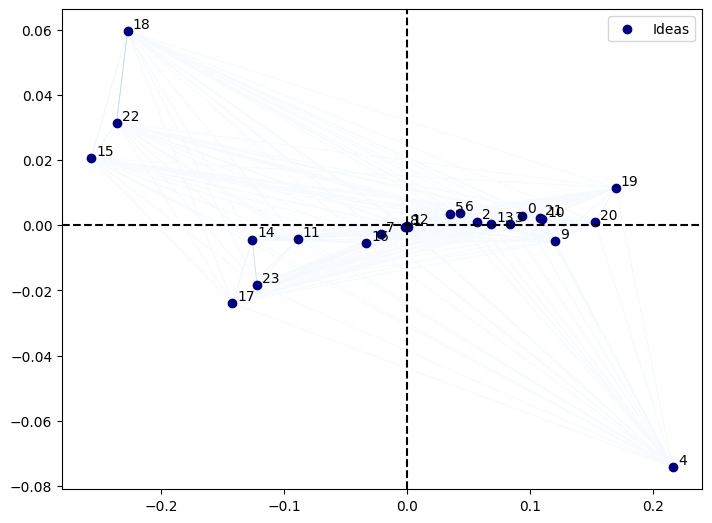

0 : Ask why clients who had a paid 1000minds license chose to stop using it. - (similarity|dist|coords): (0.74|0.0|0.09)
1 : Being acknowledged by the MCDA and CA academic worlds as a bona fide (superior) method to be taken seriously. - (similarity|dist|coords): (0.64|0.09|0.0)
2 : Build brand recognition and reputation – 1000minds as a mark or certification of a decision or prioritization well made. - (similarity|dist|coords): (0.7|0.04|0.06)
3 : Converting more leads to paying clients. - (similarity|dist|coords): (0.73|0.01|0.08)
4 : Dedicated sales team. - (similarity|dist|coords): (0.88|0.14|0.22)
5 : Despite our best efforts, sales process is a bit too casual and ad hoc (albeit we are gradually improving it). - (similarity|dist|coords): (0.68|0.06|0.03)
6 : Developing a social media strategy and posting useful content more frequently can make more people aware of our brand. - (similarity|dist|coords): (0.69|0.05|0.04)
7 : Drop the price of 1000minds licenses to a flat $1000 per us

In [8]:
# Center the data
mds = manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=1)
distances = euclidean_distances(distance_to_centroid)
coords = mds.fit_transform(distances)

# Plot
plt.title('Idea Centroid Similarity')
fig = plt.figure(1)
ax = plt.axes([0.0, 0.0, 1.0, 1.0])

plt.scatter(coords[:, 0], coords[:, 1], color="navy", label="Ideas")
plt.legend(scatterpoints=1, loc="best", shadow=False)

# Thicker connection lines if points are close to each other
EPSILON = np.finfo(np.float32).eps
line_weights = distances.max() / (distances + EPSILON) * 100
np.fill_diagonal(line_weights, 0)

# Plot the edges
start_idx, end_idx = np.where(coords)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [coords[i, :], coords[j, :]] for i in range(len(coords)) for j in range(len(coords))
]
values = np.abs(line_weights)
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.Blues, norm=plt.Normalize(0, values.max())
)
lc.set_array(line_weights.flatten())
lc.set_linewidths(np.full(len(segments), 0.5))
ax.add_collection(lc)

# Add labels to each point
labels = []
for i, dist in enumerate(coords):
    # text = f"{i}: {txt[:5]}..." if len(txt) > 5 else txt
    dist_round = round(dist[0], 2)
    text = f"{i}"
    label = ax.annotate(text, (coords[i, 0], coords[i, 1]), xytext=(5, 3), textcoords='offset pixels')
    labels.append(label)

# Adjust labels to prevent overlap - doesn't quite work though
# adjust_text(labels, arrowprops=dict(arrowstyle='->', color='black'))

# Add x and y axes
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

plt.show()

for i, item in enumerate(ideas_and_similarities):
    print(f"{i} : {item["idea"]} - (similarity|dist|coords): ({round(item["similarity"], 2)}|{round(distances[i][0], 2)}|{round(coords[i][0], 2)})")

for x, y in coords:
    print(f"({round(x, 2)}|{round(y, 2)})")

### Heatmap
Difficult to read properly. There's surely something better. (See other attempts below)

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.imshow(distance_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Similarity Score')
plt.title('Heatmap Graph of Similarity Scores')
plt.xticks(np.arange(9), np.arange(1, 10))
plt.yticks(np.arange(9), np.arange(1, 10))
plt.xlabel('Idea Index')
plt.ylabel('Idea Index')
plt.grid(visible=True, linestyle='--', linewidth=0.5)
# as_html = mpld3.fig_to_html(fig, include_libraries=False, template_type="simple")
# plt.savefig('static/plot.png')
# plt.close(fig)
plt.show()

### Networkx Graph
Not really suitable, but we might be able to improve something?

In [ ]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes to the graph
num_nodes = distance_matrix.shape[0]
for i in range(num_nodes):
    G.add_node(i)

#Add edges based on distance matrix
for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        weight = distance_matrix[i][j]
        G.add_edge(i, j, weight=weight)

# Position nodes using spring layout
coords = nx.spring_layout(G)

#Draw nodes
nx.draw_networkx_nodes(G, coords, node_size=500)

#Draw edges with weights
nx.draw_networkx_edges(G, coords)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, coords, edge_labels=edge_labels)

#Display the graph
plt.title('Distance Graph')
plt.axis('off')
plt.show()